In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: WineQT.csv              


In [2]:
!pip install torch-snippets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00


In [ ]:
#필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Scikit-learn (전처리 및 평가)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
from torch_snippets import Report # (학습 과정 로깅용)

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 기본 설정
sns.set_style('whitegrid')


In [ ]:
#@title 3. 데이터 로드 및 파라미터 설정

DATA_PATH = "/content/WineQT.csv" # <--- 이 경로를 수정하세요

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from: {DATA_PATH}")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}")
    print("Please upload the CSV file to Google Drive and update the DATA_PATH variable.")

# 불필요한 'Id' 컬럼 제거
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# 하이퍼파라미터 (원본 스니펫 참조)
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 100

# CUDA(GPU) 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

Data loaded successfully from: /content/WineQT.csv

Using device: cpu


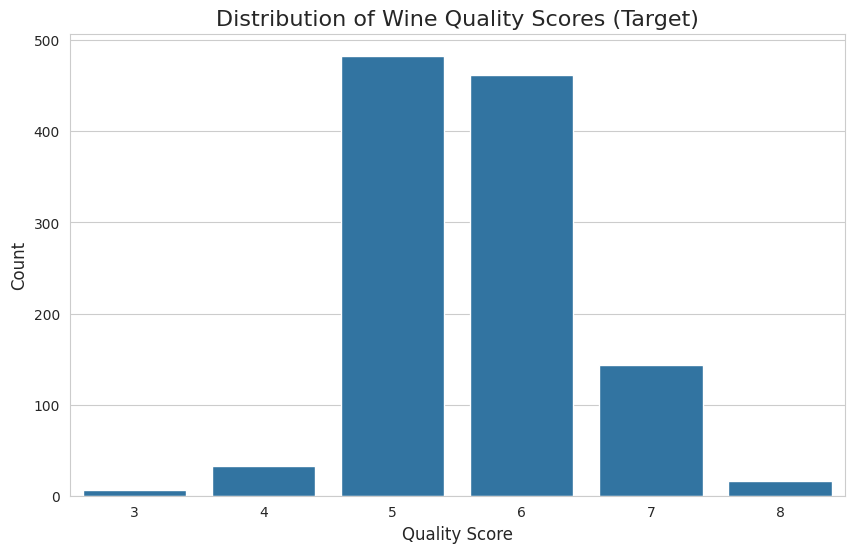

Analysis: The dataset is highly imbalanced.
Scores 5 and 6 dominate the dataset, while scores 3, 4, 7, and 8 are rare.


In [5]:
#@title 4. [EDA 보강] Target(Quality) 분포 확인 (영문 Plot)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='quality')
plt.title('Distribution of Wine Quality Scores (Target)', fontsize=16)
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

print("Analysis: The dataset is highly imbalanced.")
print("Scores 5 and 6 dominate the dataset, while scores 3, 4, 7, and 8 are rare.")


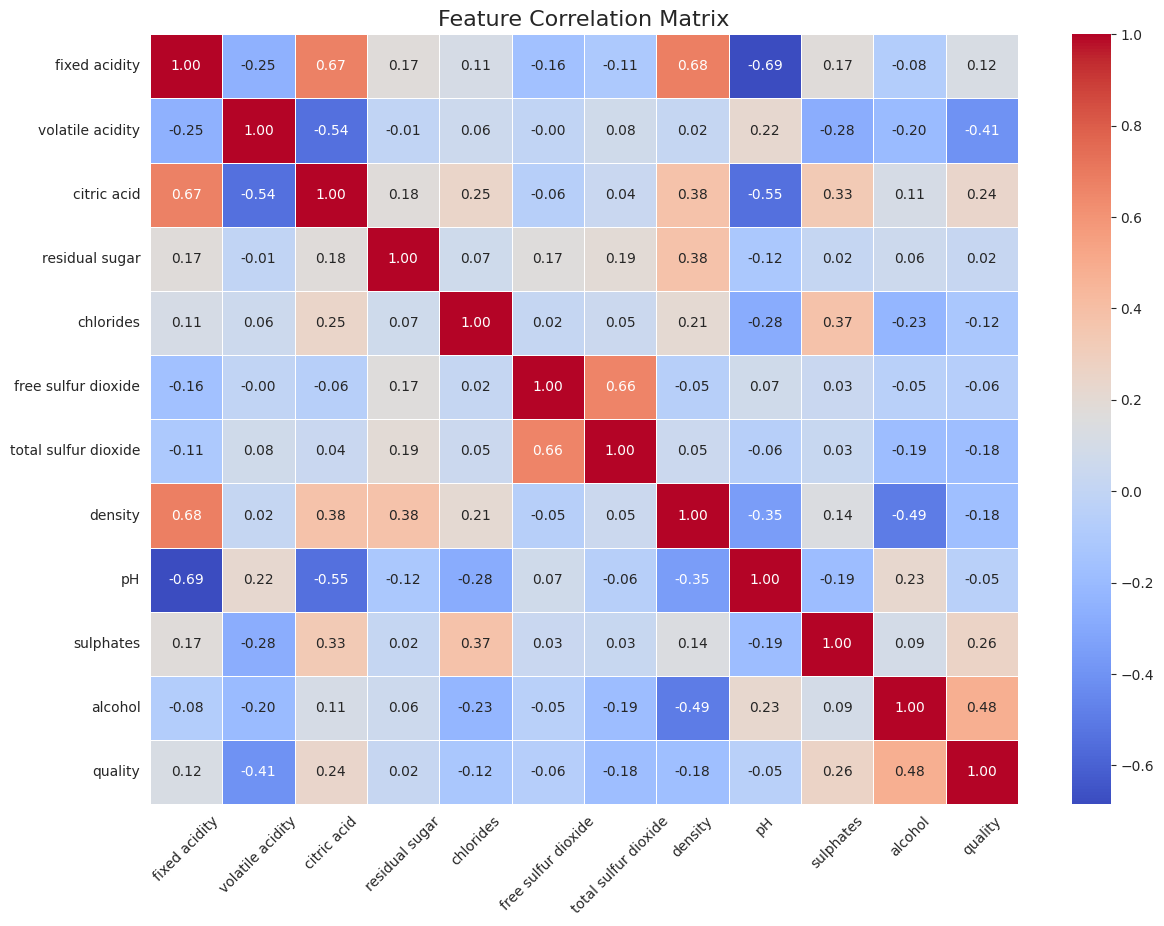


Analysis: 'alcohol' has the highest positive correlation with quality.
'volatile acidity' and 'density' show strong negative correlations.


In [6]:
#@title 5. [EDA 보강] 피처 상관관계 (Heatmap - 영문)

plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.show()

print("\nAnalysis: 'alcohol' has the highest positive correlation with quality.")
print("'volatile acidity' and 'density' show strong negative correlations.")

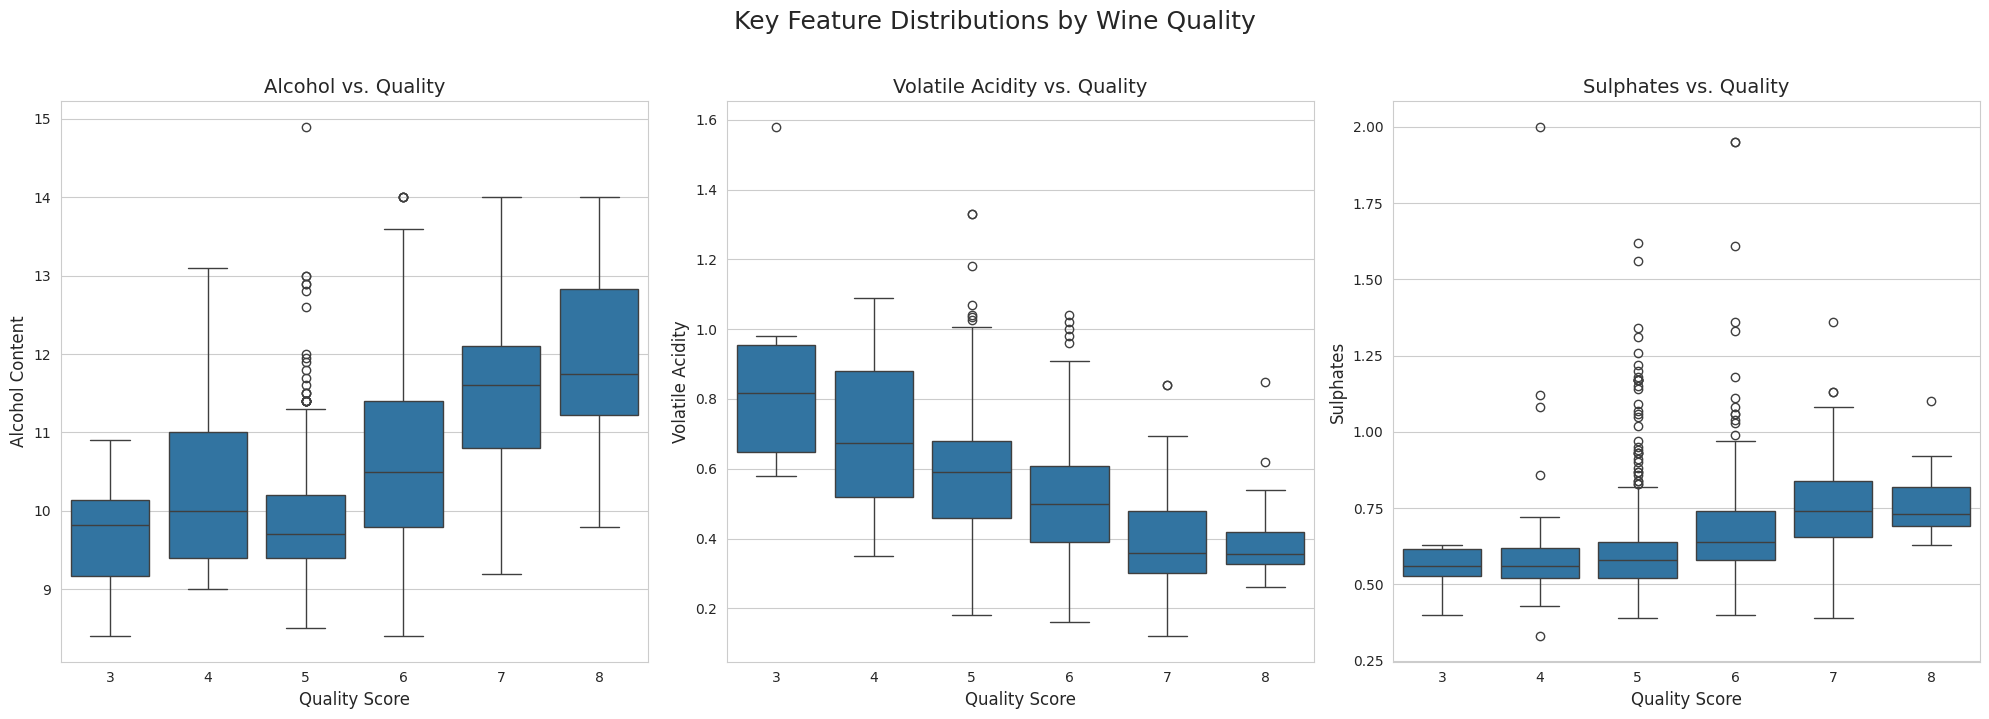

In [7]:
#@title 6. [EDA 보강] 주요 피처 vs 품질 (Box Plots - 영문)

# 품질에 영향이 큰 3가지 피처 선정 (알코올, 휘발성 산도, 황산염)
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Key Feature Distributions by Wine Quality', fontsize=18, y=1.02)

# 1. Alcohol
sns.boxplot(data=df, x='quality', y='alcohol', ax=axes[0])
axes[0].set_title('Alcohol vs. Quality', fontsize=14)
axes[0].set_xlabel('Quality Score', fontsize=12)
axes[0].set_ylabel('Alcohol Content', fontsize=12)

# 2. Volatile Acidity
sns.boxplot(data=df, x='quality', y='volatile acidity', ax=axes[1])
axes[1].set_title('Volatile Acidity vs. Quality', fontsize=14)
axes[1].set_xlabel('Quality Score', fontsize=12)
axes[1].set_ylabel('Volatile Acidity', fontsize=12)

# 3. Sulphates
sns.boxplot(data=df, x='quality', y='sulphates', ax=axes[2])
axes[2].set_title('Sulphates vs. Quality', fontsize=14)
axes[2].set_xlabel('Quality Score', fontsize=12)
axes[2].set_ylabel('Sulphates', fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
#@title 7. 데이터 전처리 (Label Encoding 및 Scaling)

# 1. X (Features) / y (Target) 분리
y_raw = df['quality']
X_raw = df.drop(columns=['quality'])
FEATURES = X_raw.columns.tolist()
N_FEATURES = len(FEATURES)

In [ ]:
# (PyTorch CrossEntropyLoss는 0-based index를 요구합니다)
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
CLASSES = le.classes_ # 원본 클래스 이름 (예: [3, 4, 5, 6, 7, 8])
N_CLASSES = len(CLASSES)

print(f"Target classes original: {CLASSES}")
print(f"Target classes encoded: {np.unique(y_enc)}")

Target classes original: [3 4 5 6 7 8]
Target classes encoded: [0 1 2 3 4 5]


In [10]:
# 3. Train / Test 데이터 분리 (불균형 데이터이므로 'stratify=y' 필수)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y_enc, # 인코딩된 y 사용
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_enc
)


In [11]:
# 4. 피처 스케일링 (RobustScaler - 원본 의도 반영)
# (이상치(outlier)에 덜 민감한 스케일러)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")



Training data shape: (914, 11)
Testing data shape: (229, 11)


In [12]:
#@title 8. PyTorch Dataset 및 DataLoader 생성

# 1. Scikit-learn (Numpy) 배열을 PyTorch Tensor로 변환
# 피처(X)는 FloatTensor, 라벨(y)은 LongTensor (CrossEntropyLoss 요구사항)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

# 2. TensorDataset과 DataLoader 생성
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("\nPyTorch DataLoaders created.")


PyTorch DataLoaders created.


In [ ]:
#@title 9. PyTorch MLP 모델 정의

class WineQualityModel(nn.Module):
    def __init__(self, n_features, n_classes, dropout_rate=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),

            nn.Linear(64, n_classes) # (CrossEntropyLoss는 Softmax를 내장함)
        )

    def forward(self, x):
        return self.model(x)

# 모델, 손실함수, 옵티마이저 초기화
model = WineQualityModel(N_FEATURES, N_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 모델 구조 확인
print("--- Model Architecture ---")
summary(model, input_size=(N_FEATURES,));


--- Model Architecture ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,536
              ReLU-2                  [-1, 128]               0
       BatchNorm1d-3                  [-1, 128]             256
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
       BatchNorm1d-7                   [-1, 64]             128
           Dropout-8                   [-1, 64]               0
            Linear-9                    [-1, 6]             390
Total params: 10,566
Trainable params: 10,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
------------------

In [15]:
#@title 10. PyTorch 학습 루프(Training Loop) 정의 및 실행 [수정됨]

def get_accuracy(preds, labels):
    """배치(batch)의 정확도를 계산하는 헬퍼 함수"""
    pred_classes = torch.argmax(preds, dim=1)
    return (pred_classes == labels).float().mean()

# torch_snippets의 Report 객체로 손실 및 정확도 로깅
log = Report(EPOCHS)

print("\nStarting model training...")

for epoch in range(EPOCHS):
    model.train() # 훈련 모드
    train_batch_loss = []
    train_batch_acc = []

    for inputs, labels in train_loader:
        # inputs, labels = inputs.to(device), labels.to(device) # (이미 7번 셀에서 device로 보냄)

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 배치별 통계 기록
        acc = get_accuracy(outputs, labels)
        train_batch_loss.append(loss.item())
        train_batch_acc.append(acc.item())

    # 검증(Validation) 단계
    model.eval() # 평가 모드 (Dropout 등 비활성화)
    val_batch_loss = []
    val_batch_acc = []

    with torch.no_grad():
        for inputs_val, labels_val in test_loader:
            # inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            val_outputs = model(inputs_val)
            val_loss = criterion(val_outputs, labels_val)
            val_acc = get_accuracy(val_outputs, labels_val)

            val_batch_loss.append(val_loss.item())
            val_batch_acc.append(val_acc.item())

    # Epoch 결과 로깅 (torch_snippets Report)
    # [수정된 부분]: 0-based 'epoch' 대신 1-based 'epoch + 1'을 전달합니다.
    log.record(
        epoch + 1,
        train_loss=np.mean(train_batch_loss),
        train_acc=np.mean(train_batch_acc),
        val_loss=np.mean(val_batch_loss),
        val_acc=np.mean(val_batch_acc),
        end='\r' # Colab에서 한 줄에 갱신되도록 출력
    )

print("\nModel training finished.")


Starting model training...
EPOCH: 100.000  train_loss: 0.689  train_acc: 0.715  val_loss: 0.921  val_acc: 0.656  (11.28s - 0.00s remaining)
Model training finished.



Plotting training history...


100%|██████████| 201/201 [00:00<00:00, 15788.14it/s]


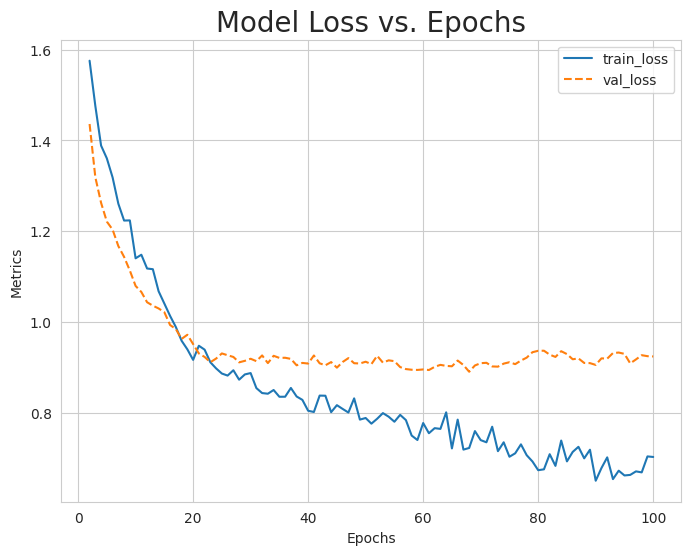

100%|██████████| 201/201 [00:00<00:00, 13669.10it/s]


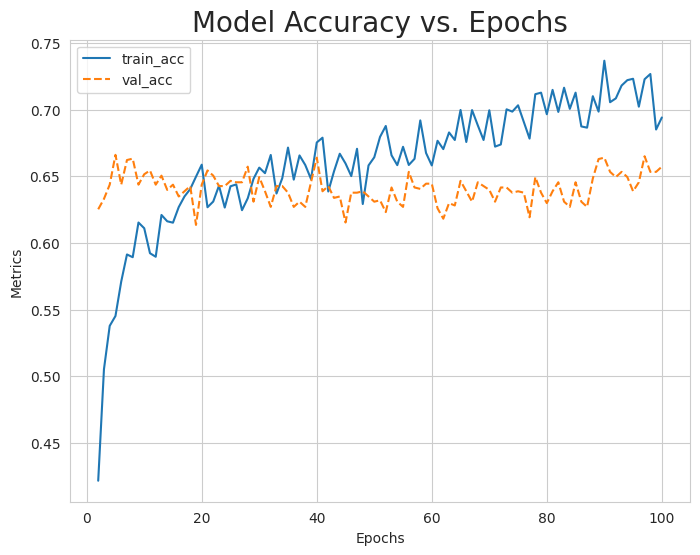

In [17]:
#@title 11. [결과 분석 보강] 학습 곡선 시각화 (Loss & Accuracy - 영문)

print("\nPlotting training history...")
log.plot_epochs(['train_loss', 'val_loss'], title="Model Loss vs. Epochs", ylabel="Cross Entropy Loss")
log.plot_epochs(['train_acc', 'val_acc'], title="Model Accuracy vs. Epochs", ylabel="Accuracy")

In [18]:
#@title 12. [결과 분석 보강] 최종 평가 (분류 리포트 및 혼동 행렬 - 영문)

print("\n--- Final Model Evaluation on Test Set ---")

# 1. 테스트 데이터셋 전체에 대한 예측 수행
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        test_outputs = model(inputs_test)
        pred_classes = torch.argmax(test_outputs, dim=1)

        all_preds.extend(pred_classes.cpu().numpy())
        all_labels.extend(labels_test.cpu().numpy())

# (y_true, y_pred는 모두 0-5 사이의 인코딩된 값입니다)
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Test Accuracy: {final_accuracy*100:.2f}%")


--- Final Model Evaluation on Test Set ---
Overall Test Accuracy: 65.07%


In [19]:
# 2. 분류 리포트 (Classification Report)
# (target_names에 LabelEncoder(le)로 찾은 원본 클래스 이름(CLASSES)을 전달합니다)
print("\n[Classification Report (English)]")
print(classification_report(all_labels, all_preds, target_names=[str(c) for c in CLASSES], zero_division=0))
print("Note: Poor scores (3, 4, 8) have low support due to severe data imbalance.")



[Classification Report (English)]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.72      0.80      0.76        97
           6       0.63      0.61      0.62        92
           7       0.52      0.52      0.52        29
           8       0.00      0.00      0.00         3

    accuracy                           0.65       229
   macro avg       0.31      0.32      0.32       229
weighted avg       0.62      0.65      0.63       229

Note: Poor scores (3, 4, 8) have low support due to severe data imbalance.



Plotting Confusion Matrix...


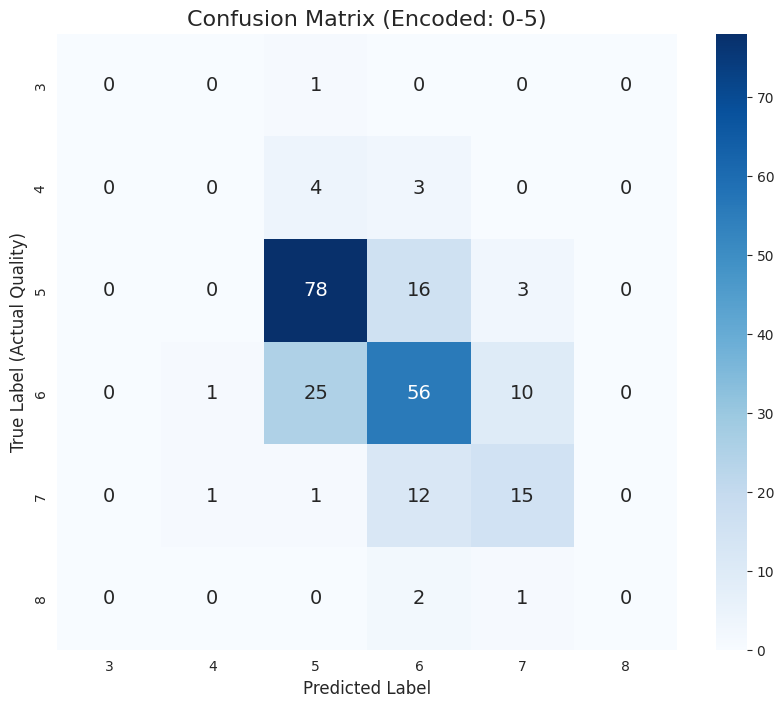

In [20]:
# 3. 혼동 행렬 (Confusion Matrix) 시각화
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(c) for c in CLASSES], # X축: 원본 라벨
            yticklabels=[str(c) for c in CLASSES], # Y축: 원본 라벨
            annot_kws={"size": 14})

plt.title('Confusion Matrix (Encoded: 0-5)', fontsize=16)
plt.ylabel('True Label (Actual Quality)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()